In [40]:
import drdf
import matplotlib.pyplot as plt
import numpy as np

In [41]:
def load_drdf(fname):
  reader = drdf.DRDF()
  reader.read(fname)
  events = []
  for run in reader.runs:
    for event in reader.runs[run]:
      hits_map = dict()
      for cam, img in reader.runs[run][event].items():
        amplitude = img.pixels[:, :, 0] 
        time = img.pixels[:, :, 1]
        hits_map[cam] = amplitude
      events.append((event, hits_map))
  return events

file = load_drdf("/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/response.drdf")

In [42]:
def CamList():
    cam_list = []
    for cam in file[0][1]:
        cam_list.append(cam)
    return cam_list

cam_list = CamList()

In [43]:
#creo una matrice 1000 righe x 54 colonne. ogni elemento è una camera 31x31
def AllImages(): 
    all_images_list = []
    for i in range(len(file)):
        ph_matrix = []
        for cam in cam_list:
            ph_matrix.append(file[i][1][cam])
        all_images_list.append(ph_matrix)
    all_images = np.array(all_images_list)
    return all_images

all_images = AllImages()

In [44]:
# creo una matrice con 1000 righe (una per ogni evento), e 51894 colonne. In ogni riga sono contenuti i pixels (31x31=961) di tutte le 54 camere in un singolo evento.
# aggiungo la dimensione 1 perchè serve per passarlo a Robust Scaler
def PixelsAllCamsPerEvents():
    pixels_to_scale = []
    for images_all_cams_per_ev in all_images: 
        pixels_all_cams_per_ev = images_all_cams_per_ev.flatten()
        pixels_to_scale.append(pixels_all_cams_per_ev)
    pixels_to_scale = np.asarray(pixels_to_scale)
    pixels_to_scale_matrix = pixels_to_scale.reshape(1000,51894,1)
    return pixels_to_scale_matrix

pixels_to_scale_matrix = PixelsAllCamsPerEvents()

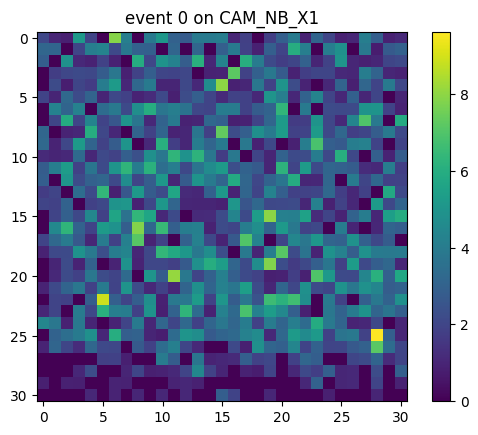

In [45]:
def PlotCamsImages():
    for i in range(len(all_images)):
        #for cam in cam_list:
        for j in range(len(all_images[i])):
            plt.imshow(all_images[i][j], interpolation='none')
            plt.colorbar()
            plt.title(f"event {file[i][0]} on {cam_list[j]}")
            plt.show()
            break
        break

PlotCamsImages()

SCALING DATA

In [46]:
from sklearn.preprocessing import RobustScaler

def ScalingData():
    photons_scaled_all_ev = []
    for pixels in pixels_to_scale_matrix:
        transformer = RobustScaler().fit(pixels)
        photons_scaled_in_cam = transformer.transform(pixels)
        photons_scaled_all_ev.append(photons_scaled_in_cam)
    photons_scaled_all_ev_matrix = np.asarray(photons_scaled_all_ev)
    all_images_scaled = photons_scaled_all_ev_matrix.reshape(1000,54,31,31)
    return all_images_scaled

all_images_scaled = ScalingData()


In [47]:
#ora ho una matrice 1000righex54colonne dove un elemento è una matrice 31x31. Per essere consistente con i dati di root la voglio trasformare in un array di 54000 elementi
def Flattening():
    all_images_scaled_1d = []
    for sublist in all_images_scaled:
        all_images_scaled_1d.extend(sublist)
    return all_images_scaled_1d

all_images_scaled_1d = np.array(Flattening())

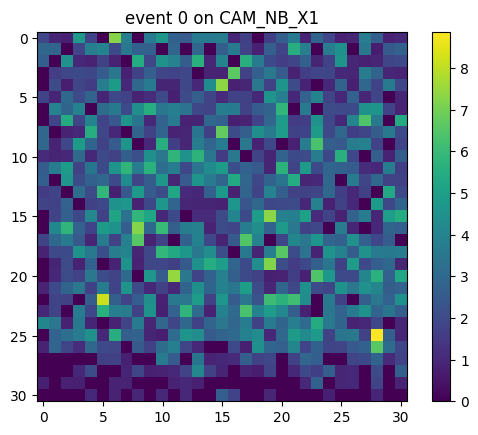

In [48]:
def PlotCamsImages():
    for i in range(len(all_images_scaled)):
        for j in range(len(all_images_scaled[i])):
            plt.imshow(all_images_scaled[i][j], interpolation='none')
            plt.colorbar()
            plt.title(f"event {file[i][0]} on {cam_list[j]}")
            plt.show()
            break
        break

PlotCamsImages()

ROOT

In [49]:
import ROOT as root

#sensor1.root è il file; ogni camera è un TTree
input_file = root.TFile.Open("/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/sensors.root", "READ")
tree = input_file.Get("CAM_NB_X1")
entries = tree.GetEntries()

cam_list = CamList()

nr_photons_list_all_cams_list = []
for cam in cam_list:
    nr_photons_list = []
    tree = input_file.Get(cam)
    for i in range(entries):
        n = tree.GetEntry(i)
        inner_photons = tree.innerPhotons
        nr_photons_list.append(inner_photons)
    nr_photons_list_all_cams_list.append(nr_photons_list)

nr_photons_list_all_cams = np.array(nr_photons_list_all_cams_list)#ho creato una matrice 1000 colonne (nr eventi) x 54 righe (nr camere). I numeri che vediamo sono i numeri di fotoni che arrivano alla camera


In [50]:
ev_list = []
for i in range(len(file)):
    ev_list.append(file[i][0])

In [51]:
def column(matrix, i):
    column = [row[i] for row in matrix]
    return column

all_photons_in_ev = []
for i in ev_list:
    nr_photons_in_ev = column(nr_photons_list_all_cams, i)#lista di fotoni in un determinato evento/sono le colonne delle matrici
    all_photons_in_ev.append(nr_photons_in_ev)#faccio una lista di queste liste di fotoni

final_root_data = []
for i in range(len(all_photons_in_ev)):
    nr_photon_in_cam = []
    for j in range(len(all_photons_in_ev[i])):
        nr_photon_in_cam.append(all_photons_in_ev[i][j])
    dict_cam_ev = dict(zip(cam_list, nr_photon_in_cam))
    final_root_data.append((ev_list[i], dict_cam_ev))
print(final_root_data)

[(0, {'CAM_NB_X1': 0, 'CAM_NB_X2': 0, 'CAM_NB_X3': 0, 'CAM_NB_X4': 0, 'CAM_NB_X5': 0, 'CAM_NB_X6': 0, 'CAM_NB_X7': 0, 'CAM_NB_X8': 0, 'CAM_NN_Y0': 0, 'CAM_NN_Y1': 100, 'CAM_NN_Y10': 0, 'CAM_NN_Y11': 0, 'CAM_NN_Y12': 0, 'CAM_NN_Y13': 301, 'CAM_NN_Y14': 0, 'CAM_NN_Y15': 0, 'CAM_NN_Y16': 337, 'CAM_NN_Y17': 0, 'CAM_NN_Y18': 0, 'CAM_NN_Y2': 0, 'CAM_NN_Y3': 0, 'CAM_NN_Y4': 0, 'CAM_NN_Y5': 0, 'CAM_NN_Y6': 0, 'CAM_NN_Y7': 0, 'CAM_NN_Y8': 0, 'CAM_NN_Y9': 0, 'CAM_NS_Y0': 0, 'CAM_NS_Y1': 0, 'CAM_NS_Y10': 0, 'CAM_NS_Y11': 0, 'CAM_NS_Y12': 0, 'CAM_NS_Y13': 0, 'CAM_NS_Y14': 0, 'CAM_NS_Y15': 0, 'CAM_NS_Y16': 0, 'CAM_NS_Y17': 0, 'CAM_NS_Y18': 0, 'CAM_NS_Y2': 0, 'CAM_NS_Y3': 0, 'CAM_NS_Y4': 0, 'CAM_NS_Y5': 0, 'CAM_NS_Y6': 0, 'CAM_NS_Y7': 0, 'CAM_NS_Y8': 0, 'CAM_NS_Y9': 0, 'CAM_NT_X1': 0, 'CAM_NT_X2': 0, 'CAM_NT_X3': 0, 'CAM_NT_X4': 0, 'CAM_NT_X5': 0, 'CAM_NT_X6': 0, 'CAM_NT_X7': 0, 'CAM_NT_X8': 0}), (1, {'CAM_NB_X1': 0, 'CAM_NB_X2': 0, 'CAM_NB_X3': 0, 'CAM_NB_X4': 0, 'CAM_NB_X5': 0, 'CAM_NB_X6': 0, 'CA

In [52]:
inner_photons_list = []
for i in range(len(final_root_data)):
    for cam in final_root_data[i][1].keys():
        inner_photons_list.append(final_root_data[i][1][cam])  

In [53]:
inner_photons_list = np.asarray(inner_photons_list)
ev_cam_state_bool = inner_photons_list > 5
ev_cam_state = ev_cam_state_bool.astype(int)

CNN MODEL

In [54]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from sklearn.model_selection import train_test_split

In [55]:
t_ds, val_ds, t_inner_ph, val_inner_ph = train_test_split(all_images_scaled_1d, inner_photons_list, train_size=0.9, random_state=42)
train_ds, test_ds, train_inner_ph, test_inner_ph = train_test_split(t_ds, t_inner_ph, train_size=0.9, random_state=42)

train_ds = np.asarray(train_ds)
val_ds = np.asarray(val_ds)
train_inner_ph = np.asarray(train_inner_ph) 
val_inner_ph = np.asarray(val_inner_ph)
test_ds = np.asarray(test_ds) 
test_inner_ph = np.asarray(test_inner_ph)

In [56]:
train_labels_bool = train_inner_ph > 5
train_labels = train_labels_bool.astype(int)

val_labels_bool = val_inner_ph > 5
val_labels = val_labels_bool.astype(int)

test_labels_bool = test_inner_ph > 5
test_labels = test_labels_bool.astype(int)

In [57]:
input_shape = [32,31,31,1]

train_ds = train_ds.reshape(int(0.9*0.9*len(all_images_scaled_1d)), 31, 31, 1)
val_ds = val_ds.reshape(int(0.1*len(all_images_scaled_1d)), 31, 31, 1)
test_ds = test_ds.reshape(int(0.1*0.9*len(all_images_scaled_1d)),31,31,1)

Augmentation

In [58]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(31,31,1)),
    layers.RandomRotation(0.2),
    #layers.RandomZoom(0.1),
    layers.RandomTranslation(0.2,0.2)
  ]
)

In [59]:
initial_bias = np.log(756/53244)

weights_0 = (1/53244)*(54000/2)
weights_1 = (1/756)*(54000/2)
weights_classes = {0: weights_0, 1: weights_1}
weights_classes

{0: 0.5070993914807302, 1: 35.714285714285715}

In [60]:
# from imblearn.over_sampling import SMOTE
# from sklearn.datasets import make_classification
# from collections import Counter

# x,y = make_classification(n_classes=2, weights=weights_classes, n_samples=54000, random_state=10)
# print(len(x),len(y))
# sm = SMOTE(random_state=42)
# x_res, y_res = sm.fit_resample(x,y)
# print(len(x_res),len(y_res))


In [61]:
#output_bias = keras.initializers.Constant(initial_bias)
model = models.Sequential()
#model.add(data_augmentation)
model.add(layers.Conv2D(8,3,padding='same', activation='ReLU', input_shape=input_shape[1:]))
model.add(layers.Conv2D(16,3,padding='same', activation='ReLU', input_shape=input_shape[1:]))
# model.add(layers.Conv2D(31,3,padding='same', activation='sigmoid', input_shape=input_shape[1:]))
# model.add(layers.Conv2D(31,3,padding='same', activation='sigmoid', input_shape=input_shape[1:]))
model.add(layers.MaxPooling2D((31,31)))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))#bias_initializer=output_bias

In [62]:
# METRICS = [
#       keras.metrics.TruePositives(name='tp'),
#       keras.metrics.FalsePositives(name='fp'),
#       keras.metrics.TrueNegatives(name='tn'),
#       keras.metrics.FalseNegatives(name='fn'), 
#       keras.metrics.BinaryAccuracy(name='accuracy'),
#       keras.metrics.Precision(name='precision'),
#       keras.metrics.Recall(name='recall'),
#       keras.metrics.AUC(name='auc'),
#       keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
# ]

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 31, 31, 8)         80        
                                                                 
 conv2d_7 (Conv2D)           (None, 31, 31, 16)        1168      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 1, 1, 16)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1265 (4.94 KB)
Trainable params: 1265 (4.94 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [63]:
epochs = 10
#callbacks = [keras.callbacks.ModelCheckpoint("/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/ultima_versione_buoni/tf_model_new/cams_model_new.keras")]
history = model.fit(train_ds, train_labels, validation_data= (val_ds, val_labels), epochs=epochs, batch_size=32, class_weight=weights_classes)

Epoch 1/10
1367/1367 [==============================] - 7s 5ms/step - loss: 0.4325 - accuracy: 0.8867 - val_loss: 0.3202 - val_accuracy: 0.9272
Epoch 2/10
1367/1367 [==============================] - 6s 5ms/step - loss: 0.3439 - accuracy: 0.9199 - val_loss: 0.4801 - val_accuracy: 0.8730
Epoch 3/10
1367/1367 [==============================] - 6s 5ms/step - loss: 0.3350 - accuracy: 0.9139 - val_loss: 0.2526 - val_accuracy: 0.9265
Epoch 4/10
1367/1367 [==============================] - 6s 5ms/step - loss: 0.3558 - accuracy: 0.9121 - val_loss: 0.3359 - val_accuracy: 0.8967
Epoch 5/10
1367/1367 [==============================] - 6s 5ms/step - loss: 0.3254 - accuracy: 0.9077 - val_loss: 0.3098 - val_accuracy: 0.8967
Epoch 6/10
1367/1367 [==============================] - 6s 5ms/step - loss: 0.3019 - accuracy: 0.9104 - val_loss: 0.2566 - val_accuracy: 0.9035
Epoch 7/10
1367/1367 [==============================] - 6s 5ms/step - loss: 0.2885 - accuracy: 0.9050 - val_loss: 0.1441 - val_accuracy:

In [64]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# def plot_metrics(history):
#   metrics = ['loss', 'accuracy', 'precision', 'recall']
#   for n, metric in enumerate(metrics):
#     name = metric.replace("_"," ").capitalize()
#     plt.subplot(2,2,n+1)
#     plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
#     plt.plot(history.epoch, history.history['val_'+metric],
#              color=colors[0], linestyle="--", label='Val')
#     plt.xlabel('Epoch')
#     plt.ylabel(name)
#     if metric == 'loss':
#       plt.ylim([0, plt.ylim()[1]])
#     elif metric == 'auc':
#       plt.ylim([0.8,1])
#     else:
#       plt.ylim([0,1])

#     plt.legend()

# plot_metrics(history=history)

In [65]:
results = model.evaluate(test_ds,test_labels)


152/152 [==============================] - 0s 1ms/step - loss: 0.2668 - accuracy: 0.9039


In [66]:
saved_model = model.save("/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/ultima_versione_buoni/tf_model_new/cams_model_new.keras")